$$
\newcommand{\genericdel}[3]{%
      \left#1{#3}\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\poisson}{Poisson}
    \DeclareMathOperator{\dif}{d}
    \newcommand{\od}[2]{\frac{\dif{#1}}{\dif{#2}}}
    \DeclareMathOperator{\Forall}{\forall}
    %
    % linear algebra
    %
    \DeclareMathOperator{\ones}{\mathbf{1}}   
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\trans}{^{\intercal}}
    \DeclareMathOperator{\trace}{trace}
$$

In [1]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
using Distributions
using RCall

# Implement Exponential Family w/ Splines

In [3]:
m = 31 # discretization resolution, odd numbers are better
# discretized space of noise-free variables:
θvec = collect(linspace(-3,3,m))
p = 5 # number of parameters
Q = convert(Matrix{Float64}, R"splines::ns($θvec, $p)")
size(Q)

(31, 5)

**Plot spline basis**

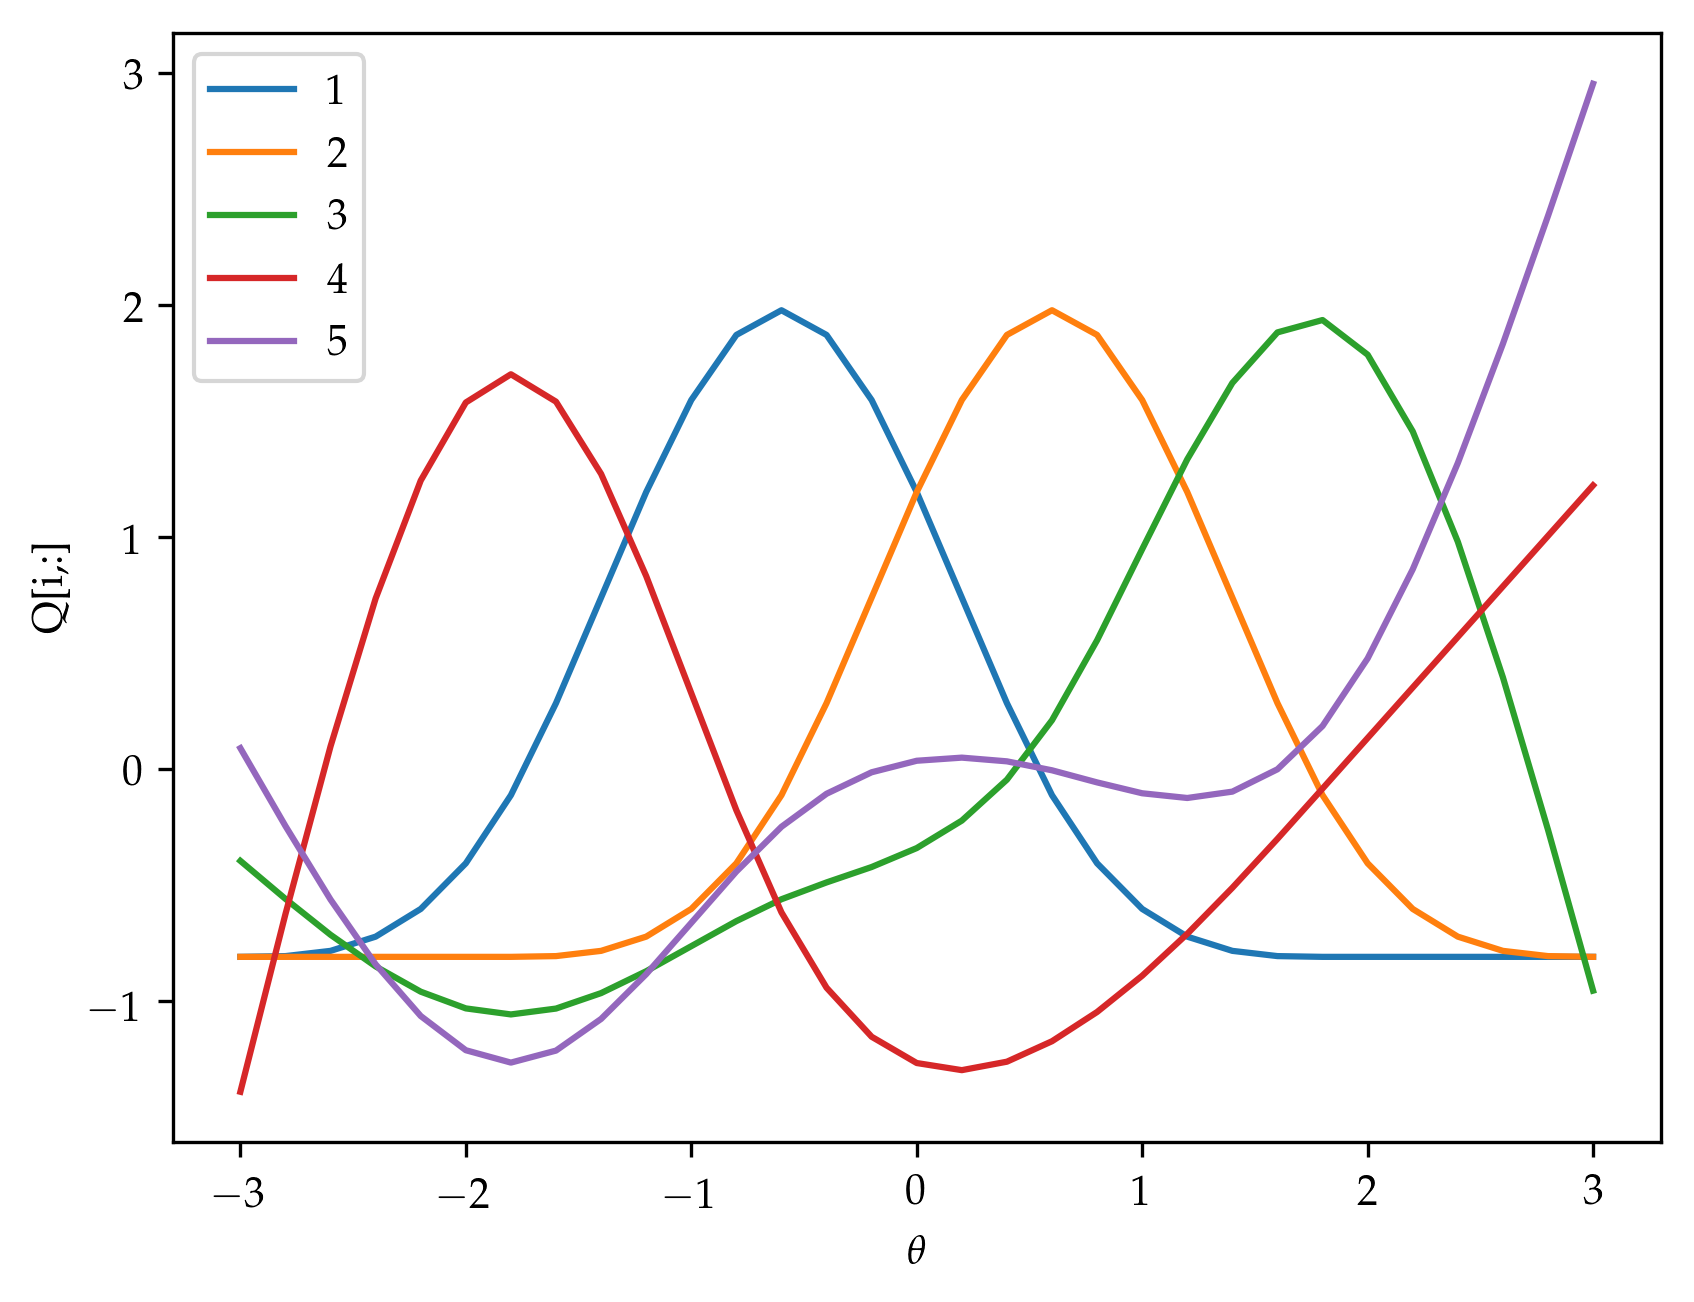

In [4]:
for param in 1:p
    # standardize
    Q[:, param] .-= mean(Q[:, param])
    Q[:, param] ./= std(Q[:, param])
    plt.plot(θvec, Q[:, param], label=string(param))
end
plt.legend(loc="best")
plt.xlabel(L"\theta")
plt.ylabel("Q[i,:]")
;

**Generate a random distribution**

We create a random distribution by using random numbers for the parameter vector $\alpha$.

In [5]:
α = randn(p)

expQα = exp.(Q*α)
φ_α = log(sum(expQα))
g_α = exp.(Q*α - φ_α) # normalized
;

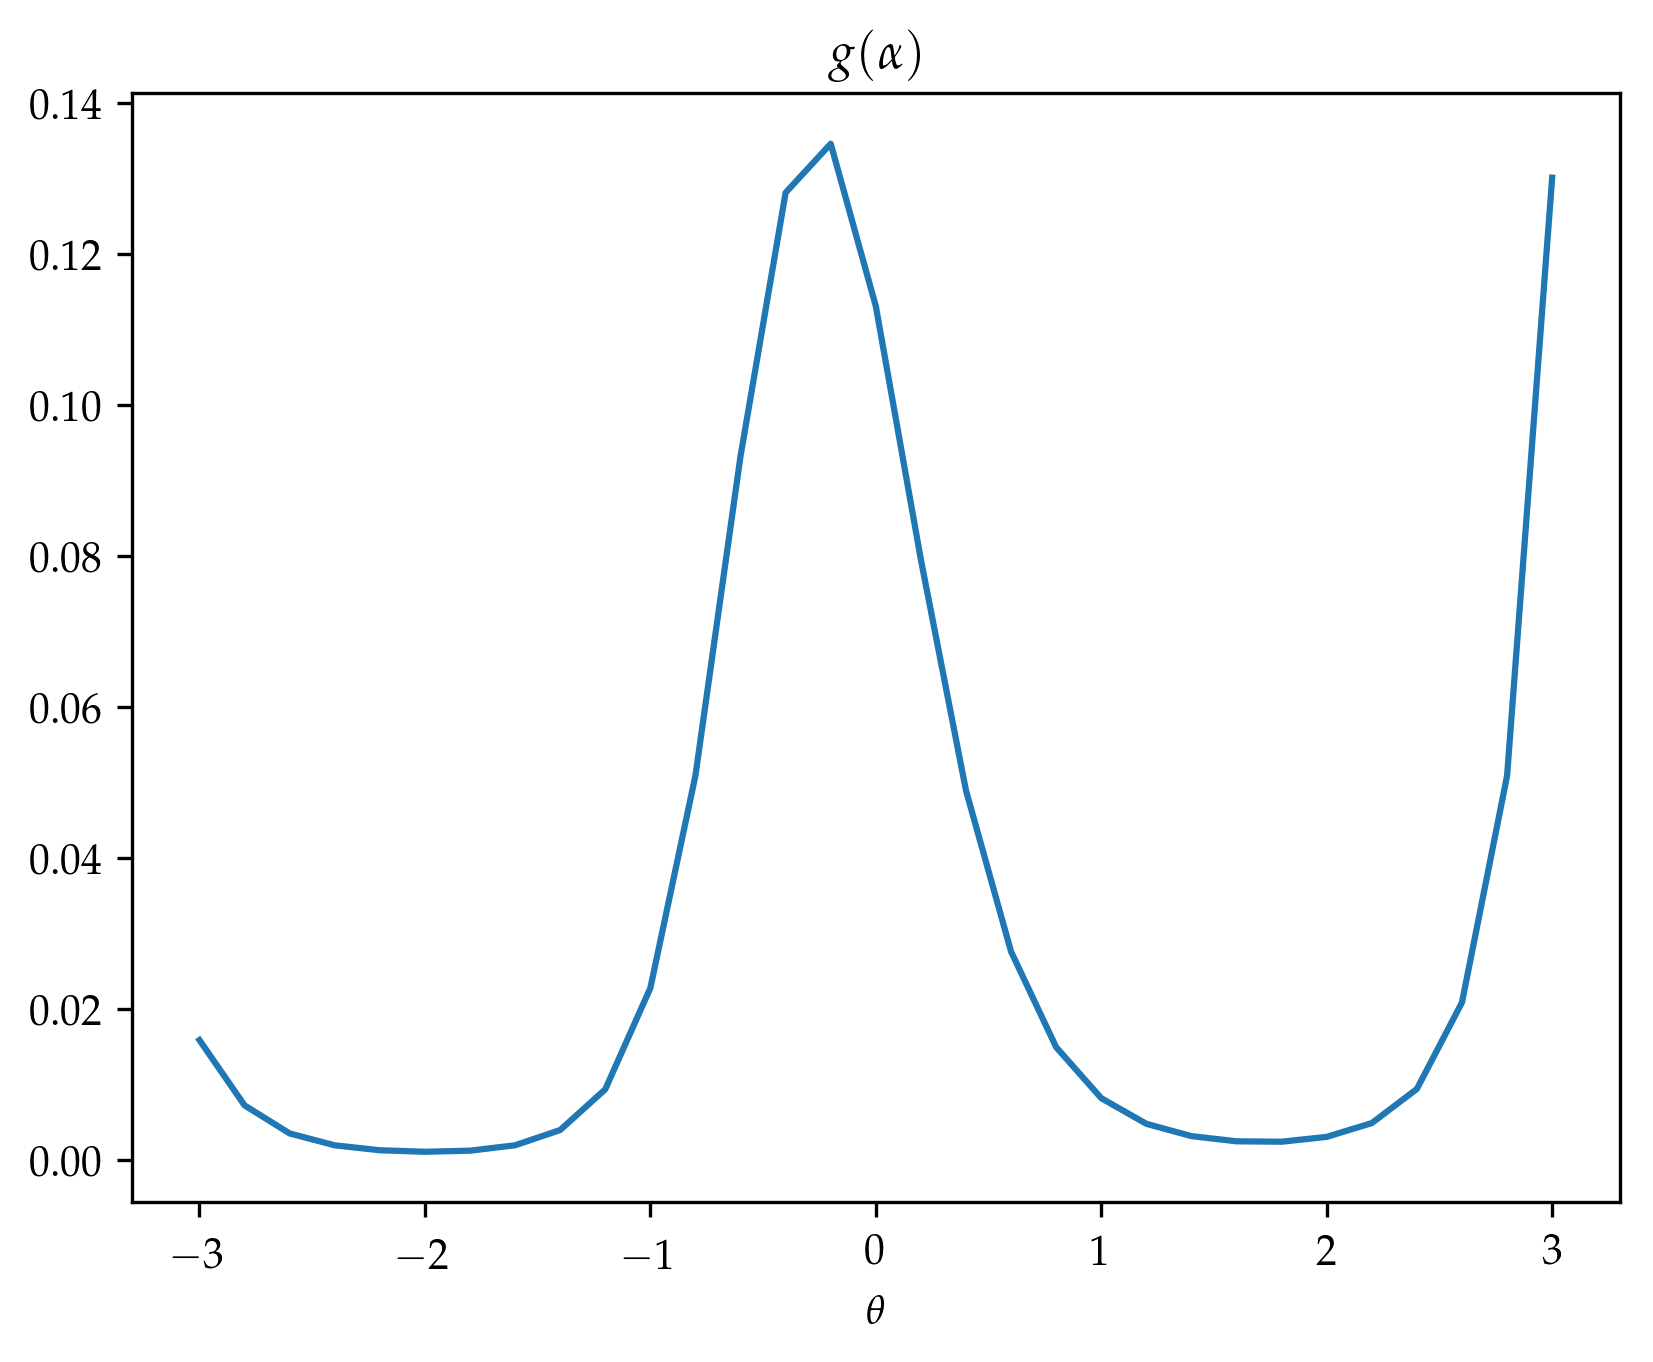

In [6]:
plt.plot(θvec, g_α)
plt.title(L"g(\alpha)")
plt.xlabel(L"\theta")
;

**Now let's do it a few times**

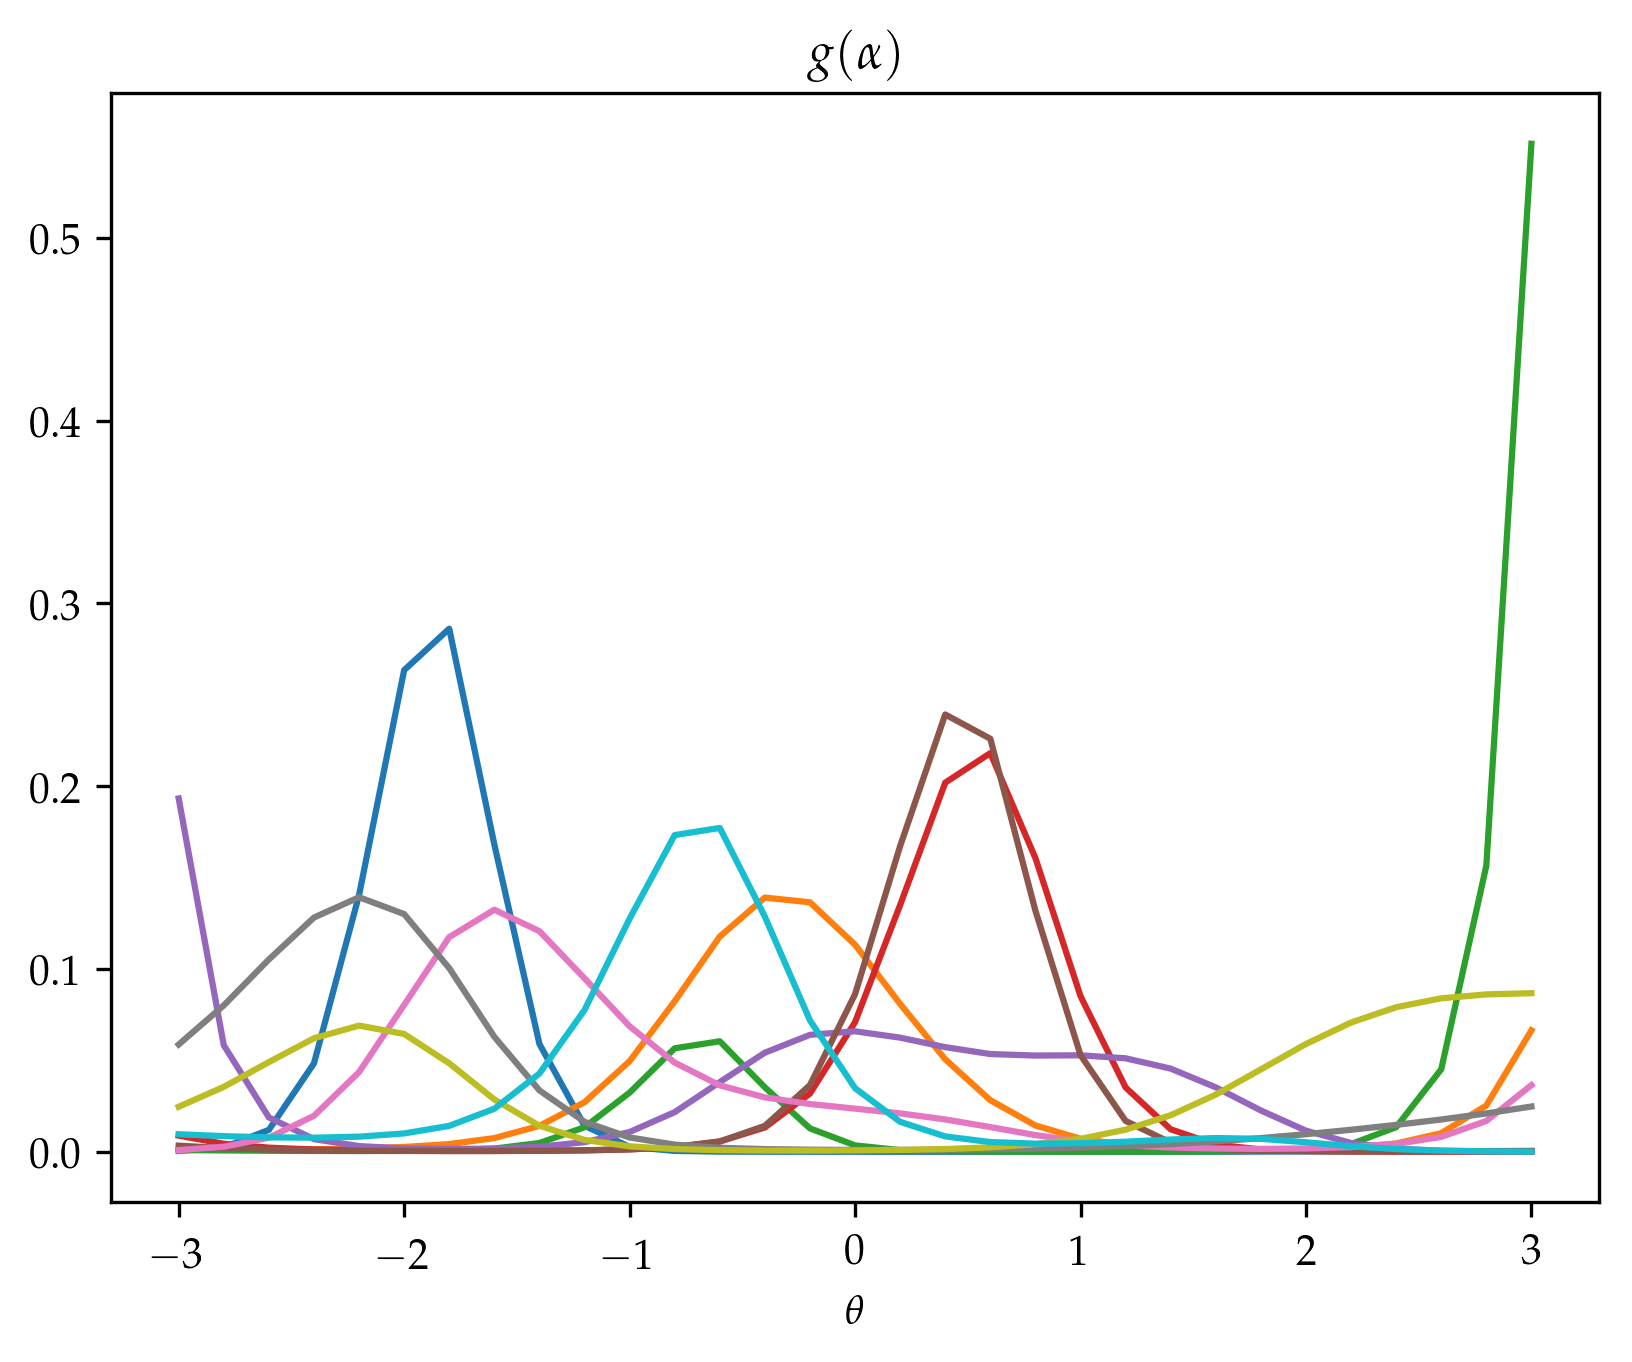

In [7]:
for _ in 1:10
    α = randn(p)
    expQα = exp.(Q*α)
    φ_α = log(sum(expQα))
    g_α = exp.(Q*α - φ_α) # normalized
    plt.plot(θvec, g_α)
end
plt.title(L"g(\alpha)")
plt.xlabel(L"\theta")
;

# Module

I put this family of distributions into a module for easy re-use.
The code is cleaned-up a bit, but there's otherwise nothing new here.

In [8]:
module ExpoFamSpline
    import Distributions: params, partype,
                          logpdf, pdf,
                          UnivariateDistribution,
                          DiscreteUnivariateDistribution, 
                          insupport
    using RCall
    function spline_basis(domain, p)
        R_spline = R"splines::ns($domain, $p)"
        Q = convert(Matrix{Float64}, R_spline)
        # standardize
        for param in 1:p
            Q[:, param] .-= mean(Q[:, param])
            Q[:, param] ./= std(Q[:, param])
        end
        return Q
    end
    
    struct ExpoSpline{T<:Real} <: DiscreteUnivariateDistribution
        domain::Vector{Float64}
        Qbasis::Matrix{Float64} # basis matrix
        αcoef::Vector{T} # α
        Qα::Vector{T}
        φ_α::T # normalization constant
    end
    function ExpoSpline(domain, Qbasis::Matrix{Float64}, αcoef::Vector{T}) where {T <: Real}
        Qα = Qbasis * αcoef
        φ_α = log_sum_exp(Qα) # equation (10)
        return ExpoSpline(domain, Qbasis, αcoef, Qα, φ_α)
    end
    function ExpoSpline(domain, αcoef::Vector{T}) where {T <: Real}
        p = length(αcoef)
        Q = spline_basis(domain, p)
        return ExpoSpline(domain, Q, αcoef)
    end 
    
    params(d::ExpoSpline) = (d.αcoef)
    partype(d::ExpoSpline{T}) where {T<:Real} = T
    insupport
    
    function log_sum_exp(x)
        # https://en.wikipedia.org/wiki/LogSumExp
        max_x = maximum(x)
        log_sum_exp_x = max_x .+ log(sum(exp.(x .- max_x)))
        return log_sum_exp_x
    end
    logpdf(d::ExpoSpline{T}) where T = d.Qα .- d.φ_α             # equation (9)
    pdf(d::ExpoSpline{T}) where T = exp.(logpdf(d))
    logpdf(d::ExpoSpline{T}, j::Int) where {T} = d.Qα[j] - d.φ_α # equation (9)
    function logpdf(d::ExpoSpline{T}, x::Real) where {T}
        j = indmin(abs.(d.domain .- x)) # not the fastest way to do this
        return logpdf(d, j)
    end
    function pdf(d::ExpoSpline{T}, x::Real) where {T}
        return exp(logpdf(d, x))
    end
    function get_logPi(domain::Vector{Float64}, noise::UnivariateDistribution, X_i::Float64)
        # unnormalized
        return logpdf.(noise, X_i.-domain)
    end
    function get_Pi(domain::Vector{Float64}, noise::UnivariateDistribution, X_i::Float64)
        # unnormalized
        return pdf.(noise, X_i.-domain)
    end
    get_logPi(d::ExpoSpline, noise, X_i) = get_logPi(d.domain, noise, X_i)
    get_Pi(d::ExpoSpline, noise, X_i) = get_Pi(d.domain, noise, X_i)
    function loglikelihood(logPi::AbstractVector{Float64}, loggα::Vector{T}) where T<:Real
        return log_sum_exp(logPi .+ loggα)
    end
    function loglikelihood(d::ExpoSpline, logPi::AbstractVector{Float64})
        loggα = logpdf(d)
        return loglikelihood(logPi, loggα)
    end
    function getWi(d::ExpoSpline, logPi::AbstractVector{Float64})
        # equation (14)-(15)
        loggα = logpdf(d)
        logfi = loglikelihood(logPi, loggα)
        Wi = exp.(loggα) .* (exp.(logPi .- logfi) .- 1)
        return Wi
    end
    function dloglik(d::ExpoSpline, logPi::AbstractVector{Float64})
        # equation (16)
        return d.Qbasis'getWi(d, logPi)
    end
    function d2loglik(d::ExpoSpline, logPi::AbstractVector{Float64})
        gα = pdf(d)
        Wi = getWi(d, logPi)
        return -d.Qbasis'*(Wi*Wi' + Wi*gα' + gα*Wi' - diagm(Wi))*d.Qbasis
    end 
    function loglikelihood(d::ExpoSpline, noise::UnivariateDistribution, X_i::Float64)
        logPi = get_logPi(d.domain, noise, X_i)
        return loglikelihood(d, logPi)
    end
end

function plot_pdf(d::ExpoFamSpline.ExpoSpline; kwargs...)
    p = pdf(d)
    θ = d.domain
    Δ = median(diff(θ))
    plt.bar(θ, p./Δ, Δ; kwargs...)
end

;

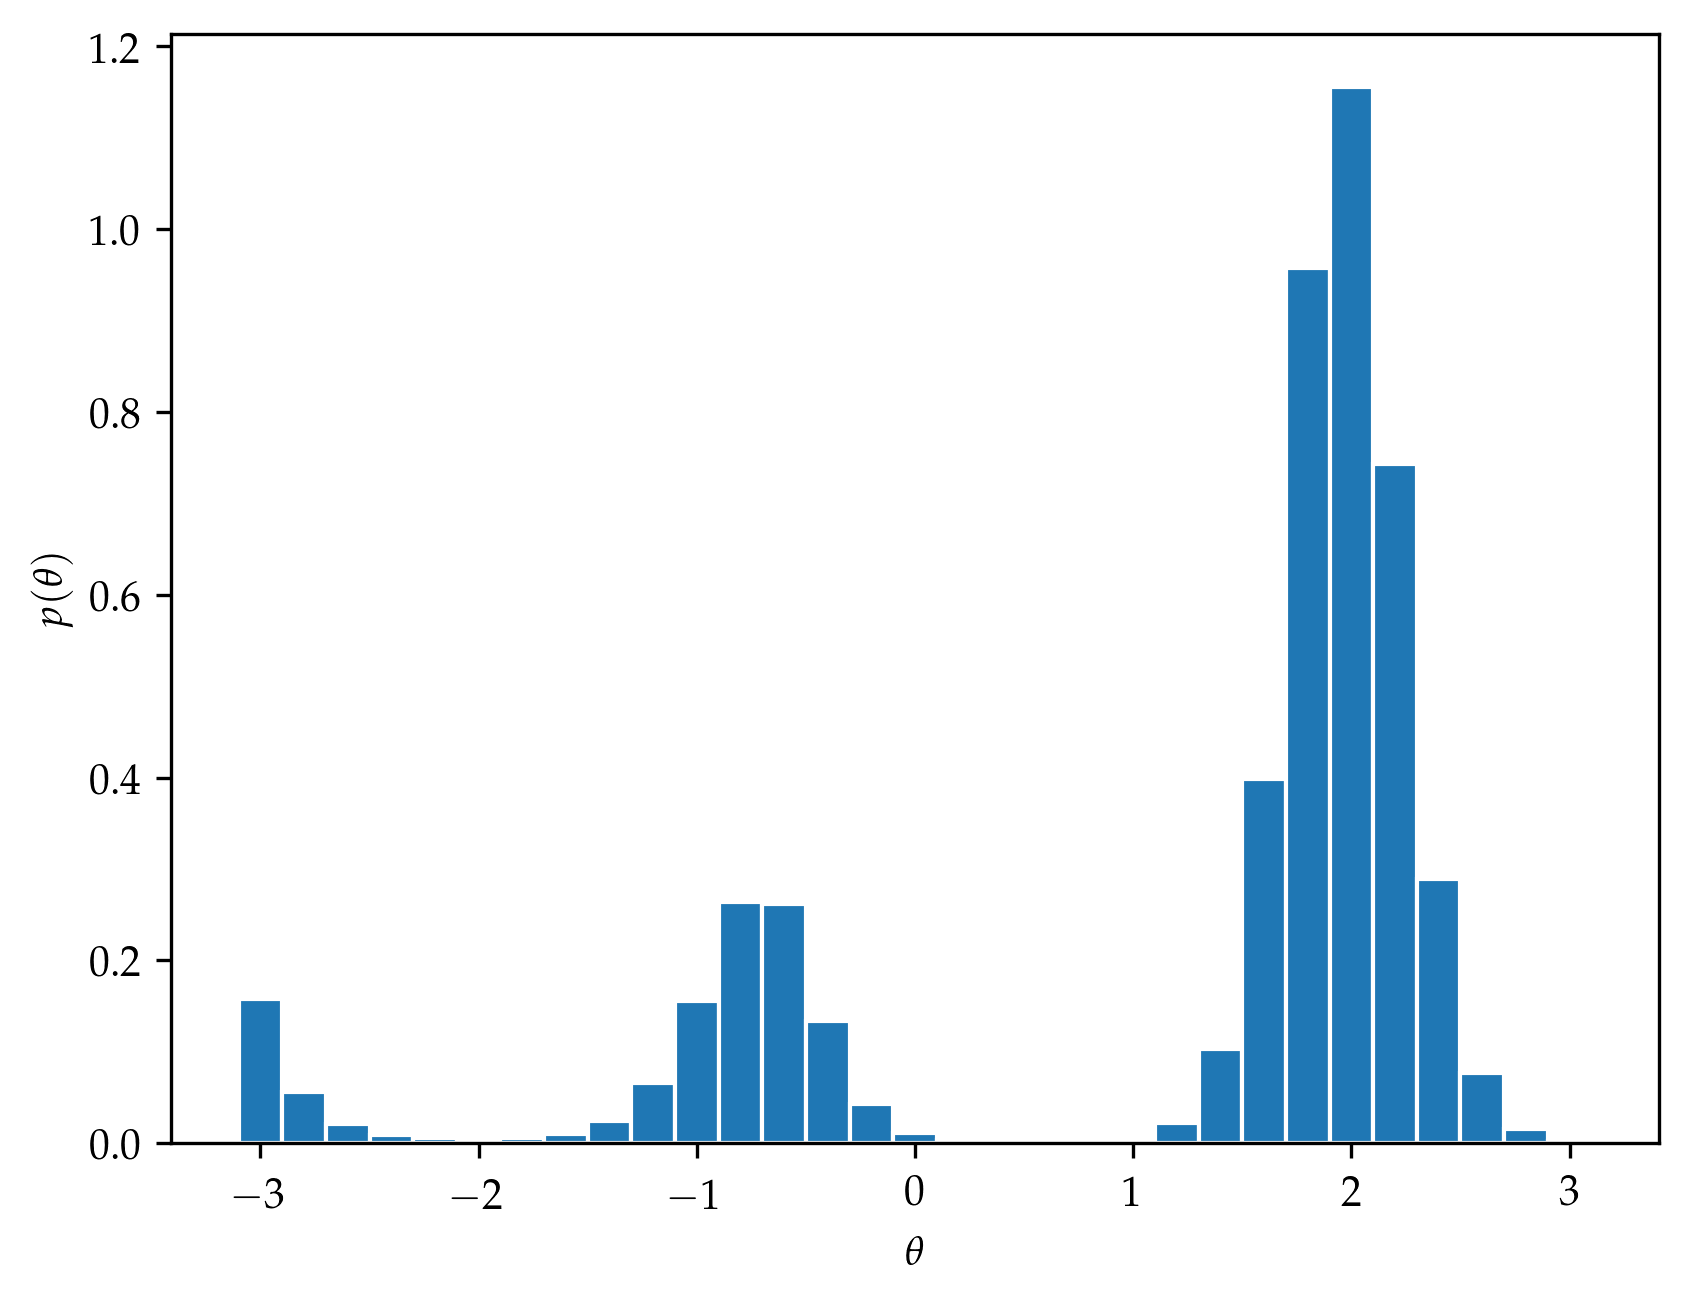

In [9]:
srand(3)
d = ExpoFamSpline.ExpoSpline(θvec, randn(5))
plot_pdf(d, edgecolor="white")
plt.xlabel(L"\theta")
plt.ylabel(L"p(\theta)")
;

# Convolution with observation distribution

> Let
> \begin{equation}
    p_{ij} = p_i(X_i \mid \Theta_i = \theta_j)
\end{equation}
> be the probability that $X_i$ equals its observed value if $\Theta_i$ equals $\theta_j$ and define $P_i$ to be the $m$-vector of possible such probabilities for $X_i$: $P_i=(p_{i1}, \dotsc, p_{im})\trans$.
> In our discrete setting, the marginal probability (6) for $X_i$ becomes
> \begin{equation}
    P(X_i \mid \alpha) = f_i(\alpha) = \sum_{j=1}^m p_{ij} g_j(\alpha) = P_i\trans g(\alpha)
    \,.
\end{equation}

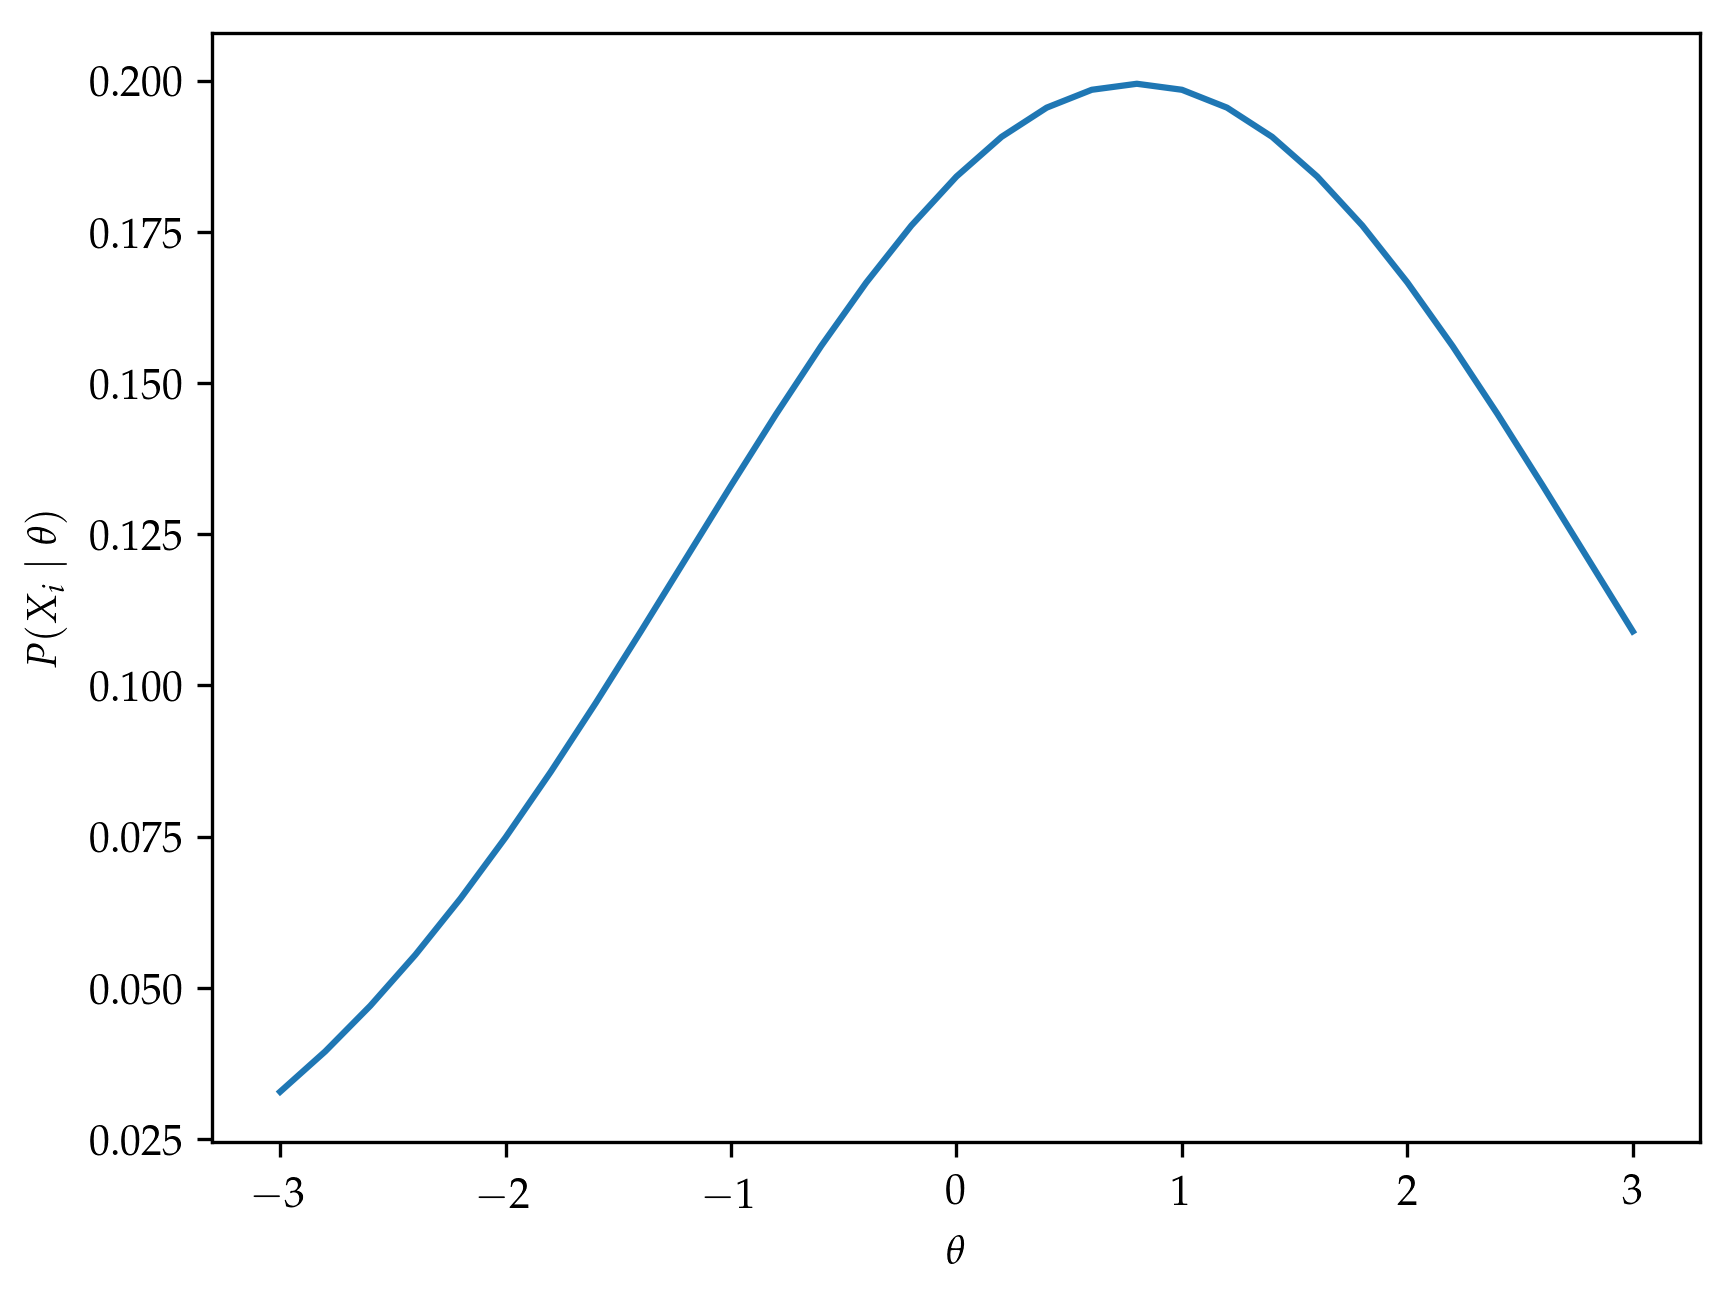

In [10]:
function get_Pi(Θdomain::Vector{Float64}, noise::UnivariateDistribution, X_i::Float64)
    # normalization?
    pdf.(noise, X_i.-Θdomain)
end
Pi = get_Pi(d.domain, Normal(0, 2), 0.8)
plt.plot(d.domain, Pi)
plt.xlabel(L"\theta")
plt.ylabel(L"P(X_i \mid \theta)")
;

In [11]:
@time ExpoFamSpline.loglikelihood(d, Normal(0, 2), 0.5)

  0.079363 seconds (54.53 k allocations: 2.531 MiB)


-1.9057725062304867

# Efron simulation

> Figure 1 illustrates an artificial deconvolution problem in which $g(\theta)$ is a mixture of one-eighth $\unif([-3,3])$ and seven-eighths $\normal(0, 0.5^2)$,
> \begin{equation}
    g(\theta) = \frac{1}{8} \frac{I_{(-3,3)}(\theta)}{6} 
    + \frac{7}{8} \frac{1}{(2\pi\sigma^2)^{1/2}}
      \exp\del{-\frac{1}{2}\frac{\theta^2}{\sigma^2}}
      ,\quad
      \sigma=0.5
      \,,
\end{equation}
> with normal observations $X_i \sim \normal(\Theta_i, 1)$ as in (5), a reduced case.

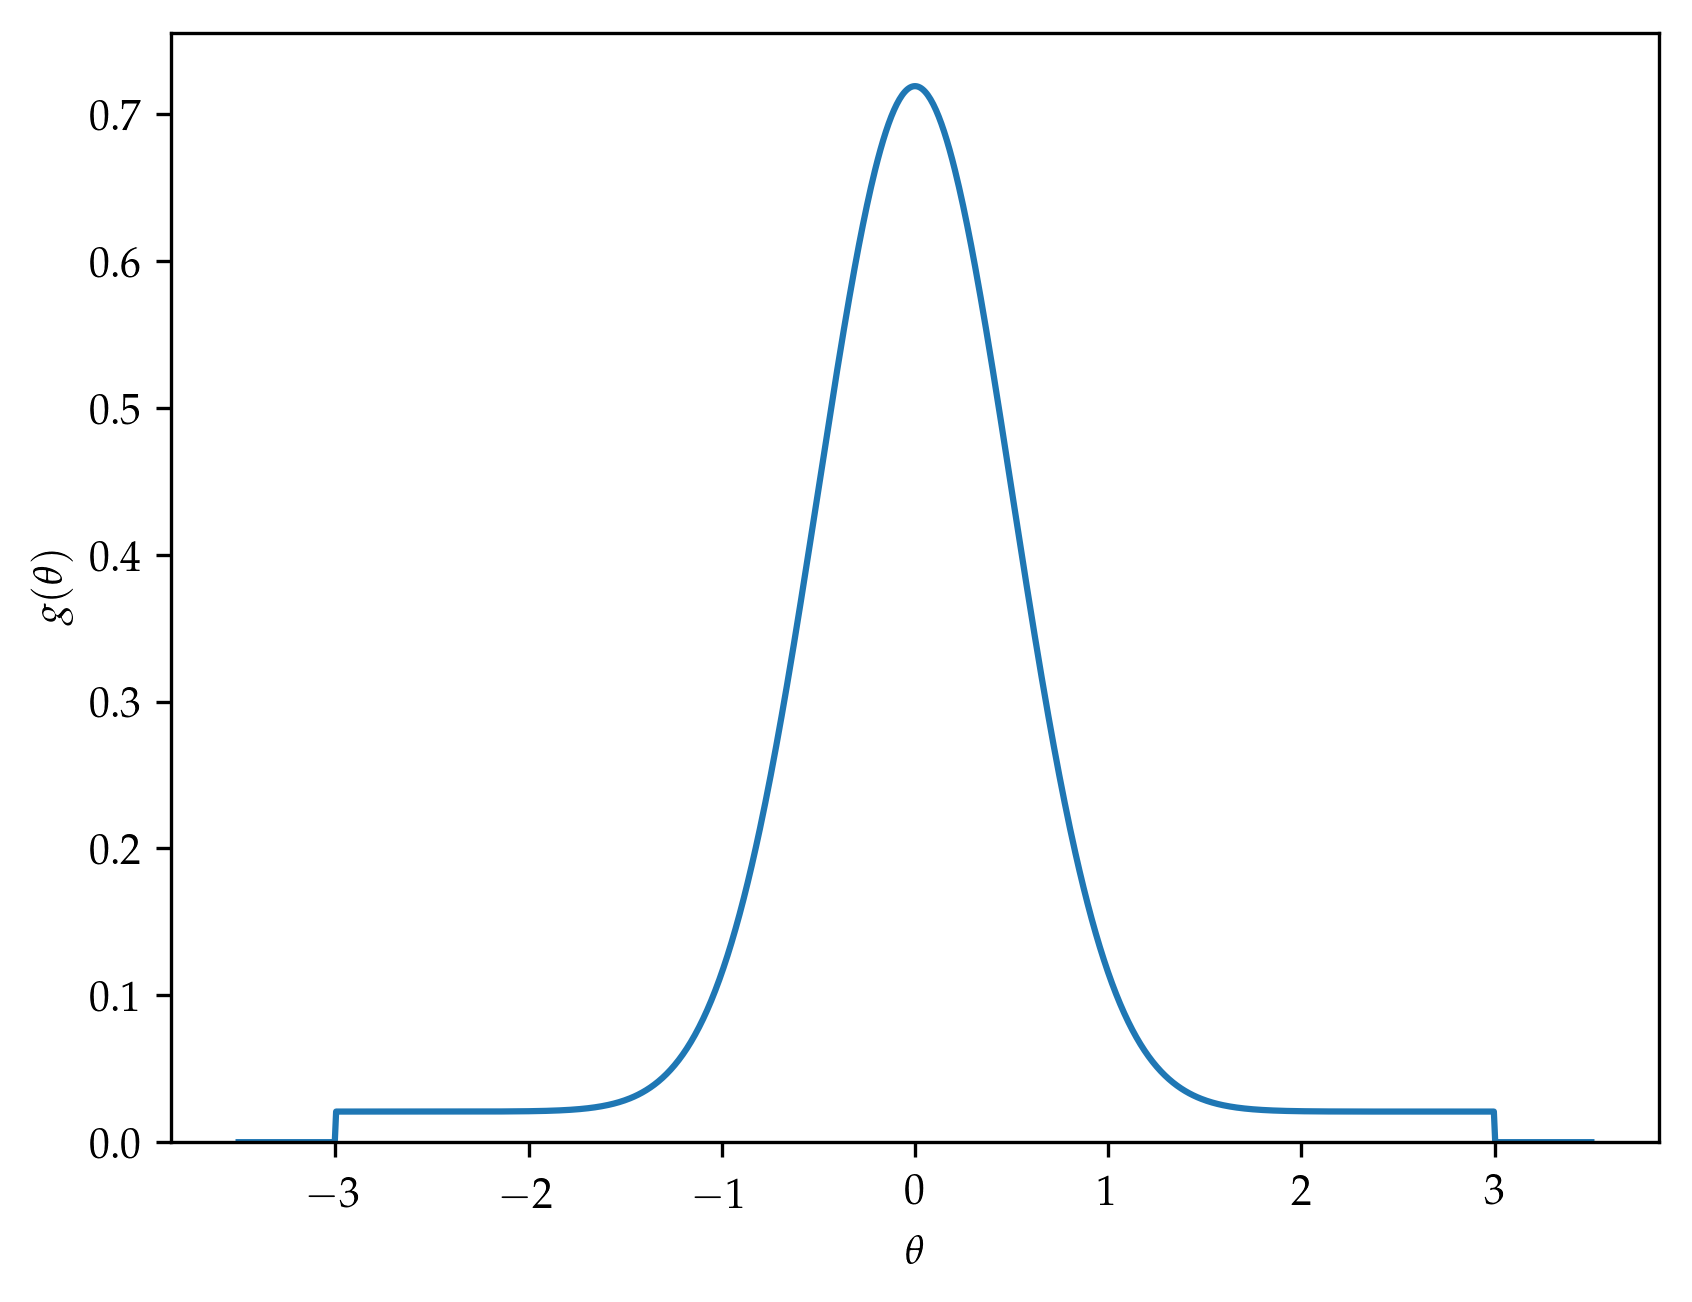

In [12]:
# Mixture models are very simple to create in julia:
example_gθ = MixtureModel(
        [Uniform(-3,3), Normal(0, 0.5)], # components
        [1/8, 7/8]                       # weights
        )
example_noise = Normal(0, 1)
xx = linspace(-3.5, 3.5, 1000)
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.ylabel(L"g(\theta)")
plt.xlabel(L"\theta")
plt.ylim(0.0)
;

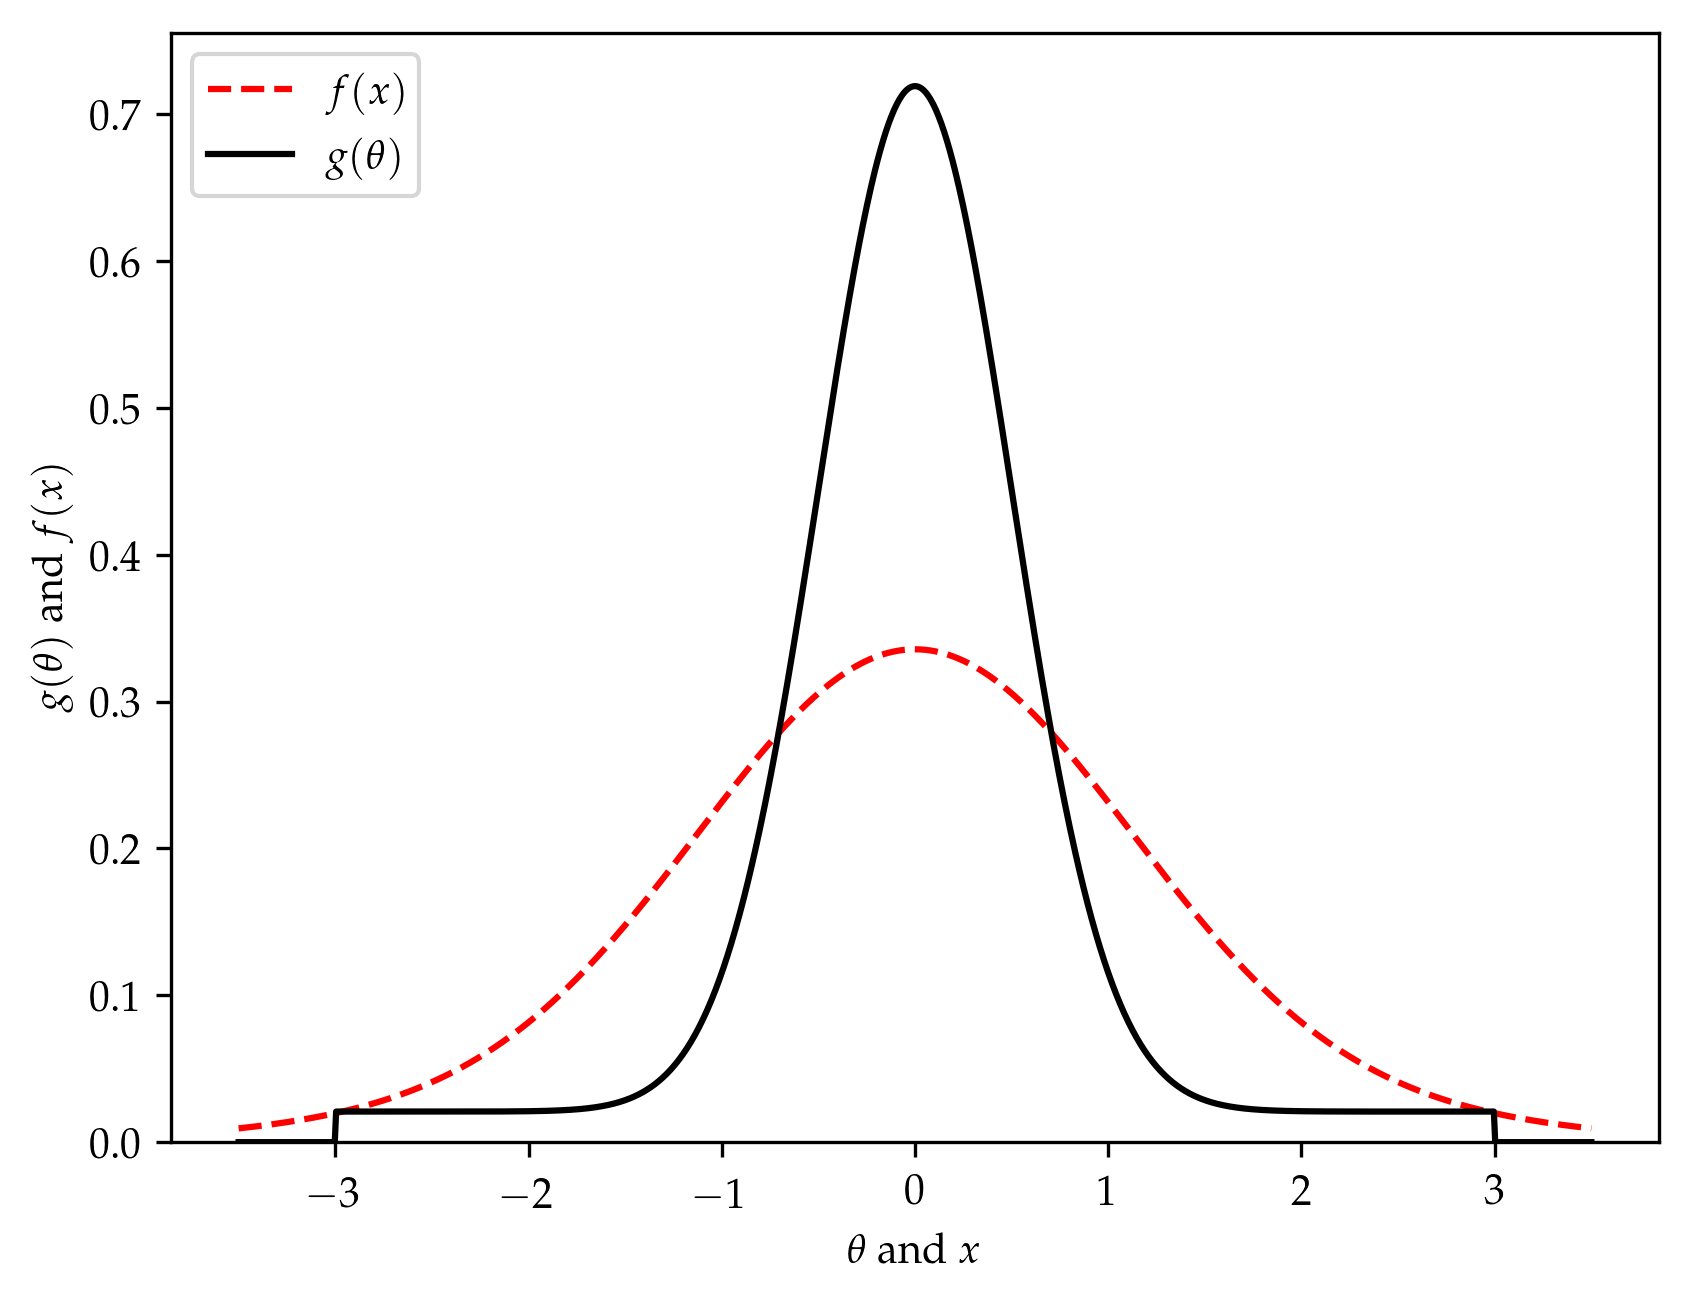

In [13]:
function convolved_log_fx(gθ::Distribution, θgrid::AbstractVector{Float64}, noise::Distribution, x_i::Float64)
    gθ_lpdf = logpdf.(gθ, θgrid)
    noise_lpdf = logpdf.(noise, x_i.-θgrid)
    return ExpoFamSpline.log_sum_exp(gθ_lpdf .+ noise_lpdf)
end

f_x_unnormalised = exp.([convolved_log_fx(example_gθ, linspace(-3.0, 3.0, 41), example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"f(x)", color="red", linestyle="--")
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)", color="black")
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.ylim(0.0)
plt.legend(loc="upper left")
;

In [14]:
N = 1000
srand(1)
θ_sim = rand(example_gθ, N)
X_sim = θ_sim .+ rand(example_noise, N)
;

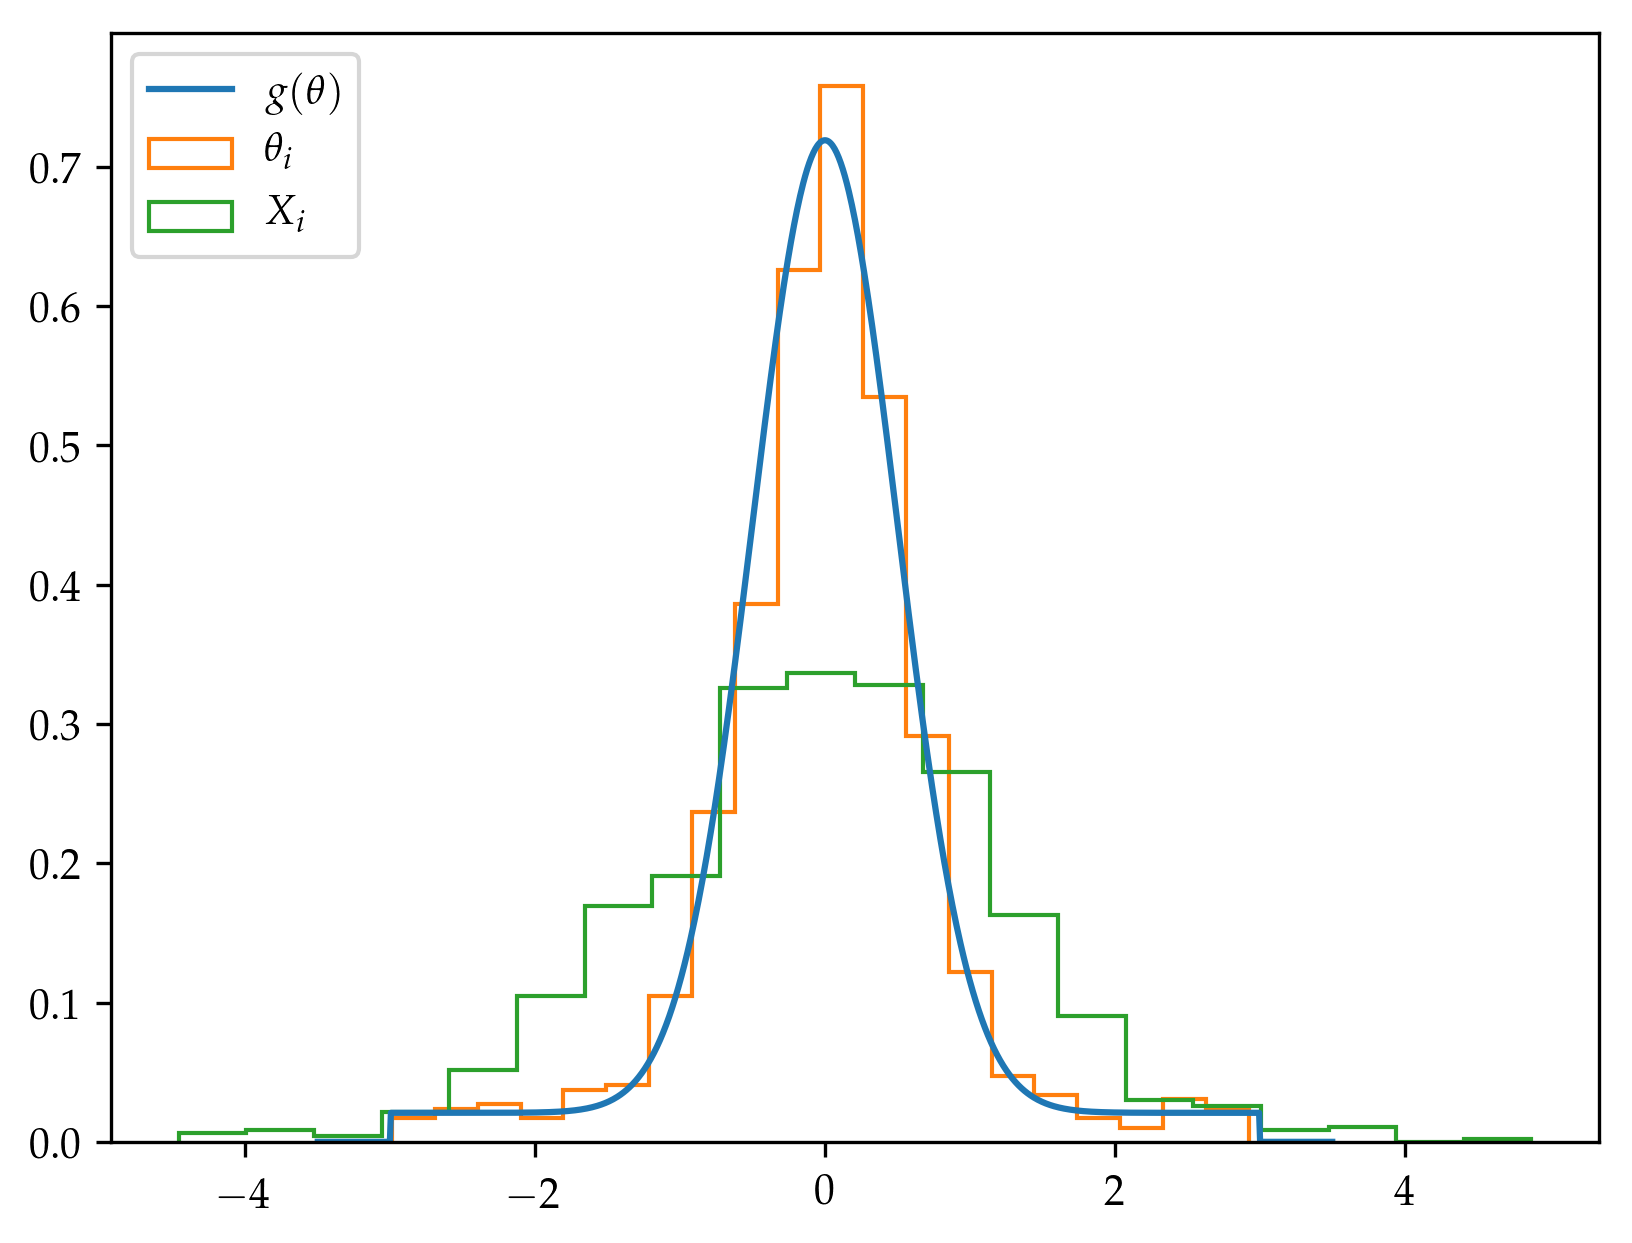

In [15]:
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
plt.plt[:hist](X_sim, histtype="step", normed=true, label=L"X_i", bins=20)
plt.legend(loc="upper left")
;

# Spline log-likelihood

## noise-free

In [16]:
# noise-free
sum(logpdf.(d, θ_sim))

-5877.943635711855

In [17]:
@time sum(logpdf.(d, θ_sim));

  0.000337 seconds (1.03 k allocations: 399.813 KiB)


## noisy

In [18]:
sum(ExpoFamSpline.loglikelihood.(d, example_noise, X_sim))

-2177.381659896972

In [19]:
@time sum(ExpoFamSpline.loglikelihood.(d, example_noise, X_sim));

  0.002279 seconds (4.06 k allocations: 1.536 MiB)


# Autodifferentiation of log-likelihood

Here we obtain the gradient of the noise-free log-likelihood using forward auto-differentiation.

In [20]:
using ForwardDiff

## noise-free

In [21]:
# create likelihood function
likelihood = α -> sum(logpdf.(ExpoFamSpline.ExpoSpline(θvec, d.Qbasis, α), θ_sim))
likelihood(d.αcoef)

-5877.943635711855

In [22]:
ForwardDiff.gradient(likelihood, d.αcoef)

5-element Array{Float64,1}:
  1166.55 
  1216.45 
 -1296.57 
  -862.225
  -370.725

On my computer, it takes less than 1 millisecond to compute the noise-free gradient of the log-likelihood with 1,000 simulated observations.

In [23]:
@time ForwardDiff.gradient(likelihood, d.αcoef);

  0.000487 seconds (1.05 k allocations: 443.016 KiB)


## noisy

In [24]:
loglik_w_noise = α -> sum(
    ExpoFamSpline.loglikelihood.(
        ExpoFamSpline.ExpoSpline(
            θvec, 
            d.Qbasis, 
            α), 
        example_noise, 
        X_sim))
loglik_w_noise(d.αcoef)

-2177.381659896972

In [25]:
ForwardDiff.gradient(loglik_w_noise, d.αcoef)

5-element Array{Float64,1}:
  721.342
   68.995
 -618.601
 -142.061
 -312.664

On my computer, it takes about 6 milliseconds to compute the noise-free gradient of the log-likelihood with 1,000 simulated observations.

In [26]:
ForwardDiff.gradient(loglik_w_noise, d.αcoef)
@time for _ in 1:100;ForwardDiff.gradient(loglik_w_noise, d.αcoef);end;

  0.411742 seconds (405.60 k allocations: 510.199 MiB, 27.71% gc time)


**Pre-compute $P_i$'s**

In [27]:
# convenience function to make optimization target
function make_loglik_w_noise_pre(d::ExpoFamSpline.ExpoSpline, noise, X::Vector{Float64})
    logP = ExpoFamSpline.get_logPi.(d, noise, X)
    mloglik_w_noise_pre = (α) -> -sum(ExpoFamSpline.loglikelihood.(
        ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α), 
        logP))
    return mloglik_w_noise_pre
end

make_loglik_w_noise_pre (generic function with 1 method)

In [28]:
f = make_loglik_w_noise_pre(d, example_noise, X_sim)
f(d.αcoef)

2177.381659896972

It's a little bit faster (4 ms instead of 6 ms).

In [29]:
ForwardDiff.gradient(f, d.αcoef)

5-element Array{Float64,1}:
 -721.342
  -68.995
  618.601
  142.061
  312.664

In [30]:
@time for _ in 1:100;ForwardDiff.gradient(f, d.αcoef);end;

  0.331714 seconds (400.80 k allocations: 481.042 MiB, 28.73% gc time)


# Analytical differentiation of log-likelihood

In [32]:
function make_dloglik(d::ExpoFamSpline.ExpoSpline, noise, X::Vector{Float64})
    logP = ExpoFamSpline.get_logPi.(d, noise, X)
    dloglik = function(α::Vector{Float64})
        d_α = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α)
        gradient = zeros(d.αcoef)
        for i in 1:length(X)
            gradient .+= ExpoFamSpline.dloglik(d_α, logP[i])
        end
        return gradient
    end
    return dloglik
end     

make_dloglik (generic function with 1 method)

In [33]:
df = make_dloglik(d, example_noise, X_sim)
df(d.αcoef) # same as autodiff answer (up to sign difference)

5-element Array{Float64,1}:
  721.342
   68.995
 -618.601
 -142.061
 -312.664

In [34]:
@time for _ in 1:100;df(d.αcoef) ;end;

  0.229173 seconds (500.40 k allocations: 164.888 MiB, 23.59% gc time)


## hessian

In [35]:
function make_d2loglik(d::ExpoFamSpline.ExpoSpline, noise, X::Vector{Float64})
    logP = ExpoFamSpline.get_logPi.(d, noise, X)
    npars = length(d.αcoef)
    d2loglik = function(α::Vector{Float64})
        d_α = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α)
        hess = zeros(npars, npars)
        for i in 1:length(X)
            hess .+= ExpoFamSpline.d2loglik(d_α, logP[i])
        end
        return hess
    end
    return d2loglik
end     

make_d2loglik (generic function with 1 method)

In [36]:
ForwardDiff.hessian(f, d.αcoef)

5×5 Array{Float64,2}:
   34.898      3.25475  -156.486   -25.0409  -144.774 
    3.25475  -14.1933     33.6154   42.9475   -64.2033
 -156.486     33.6154    357.816    91.583    100.514 
  -25.0409    42.9475     91.583   -42.5955   138.87  
 -144.774    -64.2033    100.514   138.87     146.267 

In [37]:
@time ForwardDiff.hessian(f, d.αcoef);

  0.026011 seconds (4.02 k allocations: 26.679 MiB, 29.62% gc time)


In [38]:
d2f = make_d2loglik(d, example_noise, X_sim)
d2f(d.αcoef) # should be same as autodiff answer

5×5 Array{Float64,2}:
 -34.898     -3.25475   156.486     25.0409   144.774 
  -3.25475   14.1933    -33.6154   -42.9475    64.2033
 156.486    -33.6154   -357.816    -91.583   -100.514 
  25.0409   -42.9475    -91.583     42.5955  -138.87  
 144.774     64.2033   -100.514   -138.87    -146.267 

In [39]:
@time d2f(d.αcoef) # should be same as autodiff answer

  0.023327 seconds (17.01 k allocations: 59.053 MiB, 29.07% gc time)


5×5 Array{Float64,2}:
 -34.898     -3.25475   156.486     25.0409   144.774 
  -3.25475   14.1933    -33.6154   -42.9475    64.2033
 156.486    -33.6154   -357.816    -91.583   -100.514 
  25.0409   -42.9475    -91.583     42.5955  -138.87  
 144.774     64.2033   -100.514   -138.87    -146.267 

We get the same answer using analytical gradients and Hessians as using forward autodifferentiation, and the performance is about the same.
It might be possible to rewrite the autodifferentiation code but I'm not convinced it's worth the effort over using autodifferentiation.

# Optimize log-likelihood

In [40]:
using Optim

## fitting noise-free data

In [41]:
function make_loglik_noisefree(d::ExpoFamSpline.ExpoSpline, θ::Vector{Float64})
    mloglik = (α) -> -sum(
        ExpoFamSpline.logpdf.( # compute the log-PDF under the…
            ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α), # …candidate distribution…
            θ # …of the noise-free data
            )
        )
    return mloglik
end

f = make_loglik_noisefree(d, θ_sim)
td = TwiceDifferentiable(f, copy(d.αcoef); autodiff=:forward)
@time nf_opt_out = optimize(td, zeros(d.αcoef), Optim.Newton())

  4.711484 seconds (3.92 M allocations: 217.017 MiB, 2.53% gc time)


Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [0.8159420739691221,0.9474602615858975, ...]
 * Minimum: 2.669621e+03
 * Iterations: 6
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 4.65e-11 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 7.50e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.01e-13 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 16
 * Gradient Calls: 16
 * Hessian Calls: 6

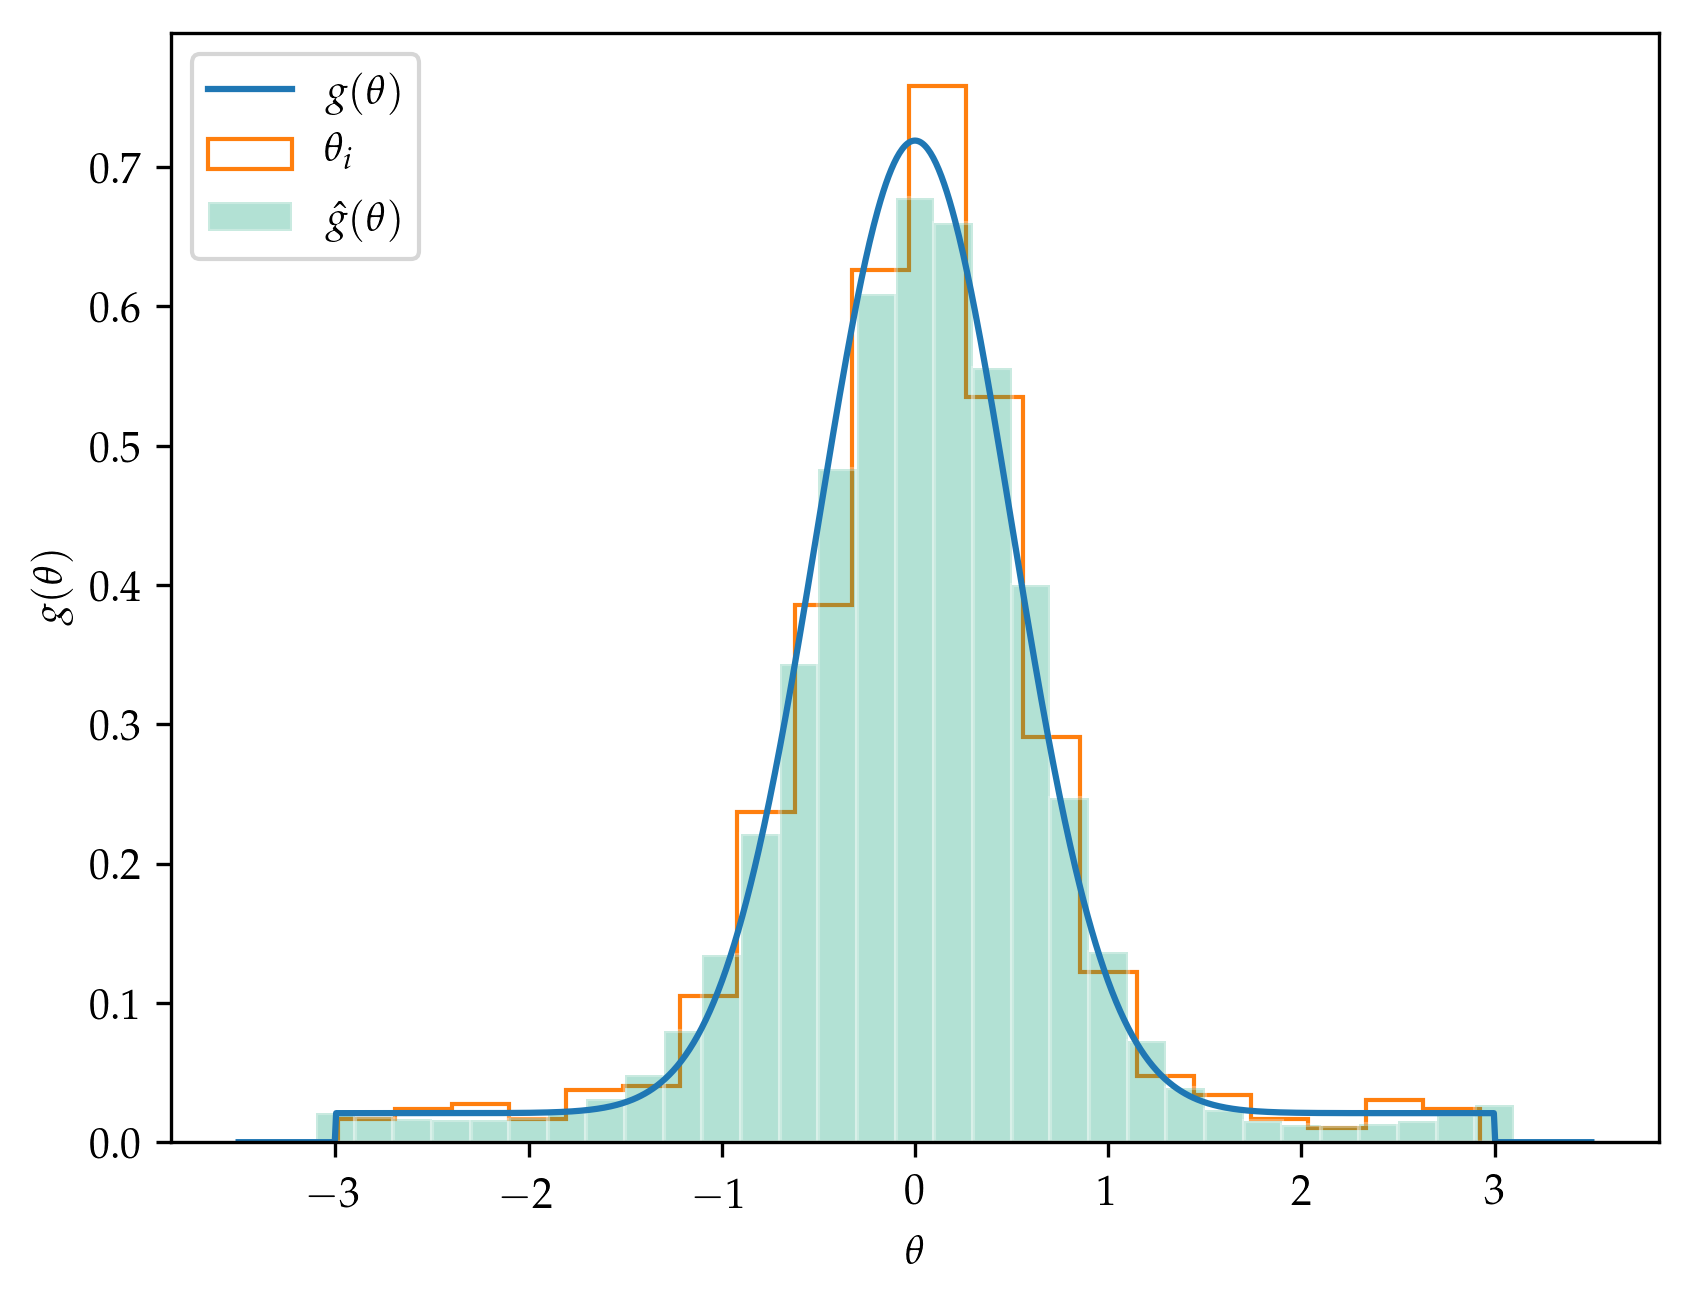

In [42]:
nf_optim = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, Optim.minimizer(nf_opt_out))

plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
_ylim = plt.ylim()
plot_pdf(nf_optim, label=L"\hat{g}(\theta)"; facecolor=cbbPalette[3], edgecolor="white", alpha=0.3)
plt.ylim(_ylim)
plt.ylabel(L"$g(\theta)$")
plt.xlabel(L"$\theta$")
plt.legend(loc="upper left")
;

## fitting noisy data

In [43]:
f = make_loglik_w_noise_pre(d, example_noise, X_sim)
td = TwiceDifferentiable(f, copy(d.αcoef); autodiff=:forward)
@time opt_out = optimize(td, ones(d.αcoef), ConjugateGradient())

  4.313328 seconds (6.40 M allocations: 4.241 GiB, 17.89% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [1.0,1.0,1.0,1.0,1.0]
 * Minimizer: [0.5955169531770946,1.2621324705394195, ...]
 * Minimum: 1.622219e+03
 * Iterations: 540
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 6.28e-07 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 2.80e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.13e-05 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 1223
 * Gradient Calls: 756

In [44]:
f = make_loglik_w_noise_pre(d, example_noise, X_sim)
td = TwiceDifferentiable(f, copy(d.αcoef); autodiff=:forward)
@time opt_out = optimize(td, ones(d.αcoef), Optim.BFGS())
# doesn't reach the minimum! boo!

  0.383620 seconds (170.06 k allocations: 23.196 MiB, 2.31% gc time)


Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.0,1.0,1.0,1.0,1.0]
 * Minimizer: [2857.849967616915,1874.8685602423654, ...]
 * Minimum: 1.695247e+03
 * Iterations: 1
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 3.02e+03 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 2.16e-01 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.54e-44 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 3
 * Gradient Calls: 3

In [45]:
td = TwiceDifferentiable(f, copy(d.αcoef); autodiff=:forward)
@time opt_out = optimize(td, zeros(d.αcoef), Optim.Newton())

  0.569213 seconds (489.19 k allocations: 938.941 MiB, 24.27% gc time)


Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [0.5955236312908181,1.262113657823418, ...]
 * Minimum: 1.622219e+03
 * Iterations: 18
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.41e-08 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 2.80e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.29e-13 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 95
 * Gradient Calls: 95
 * Hessian Calls: 18

In [46]:
f(Optim.minimizer(nf_opt_out))

1624.259045956093

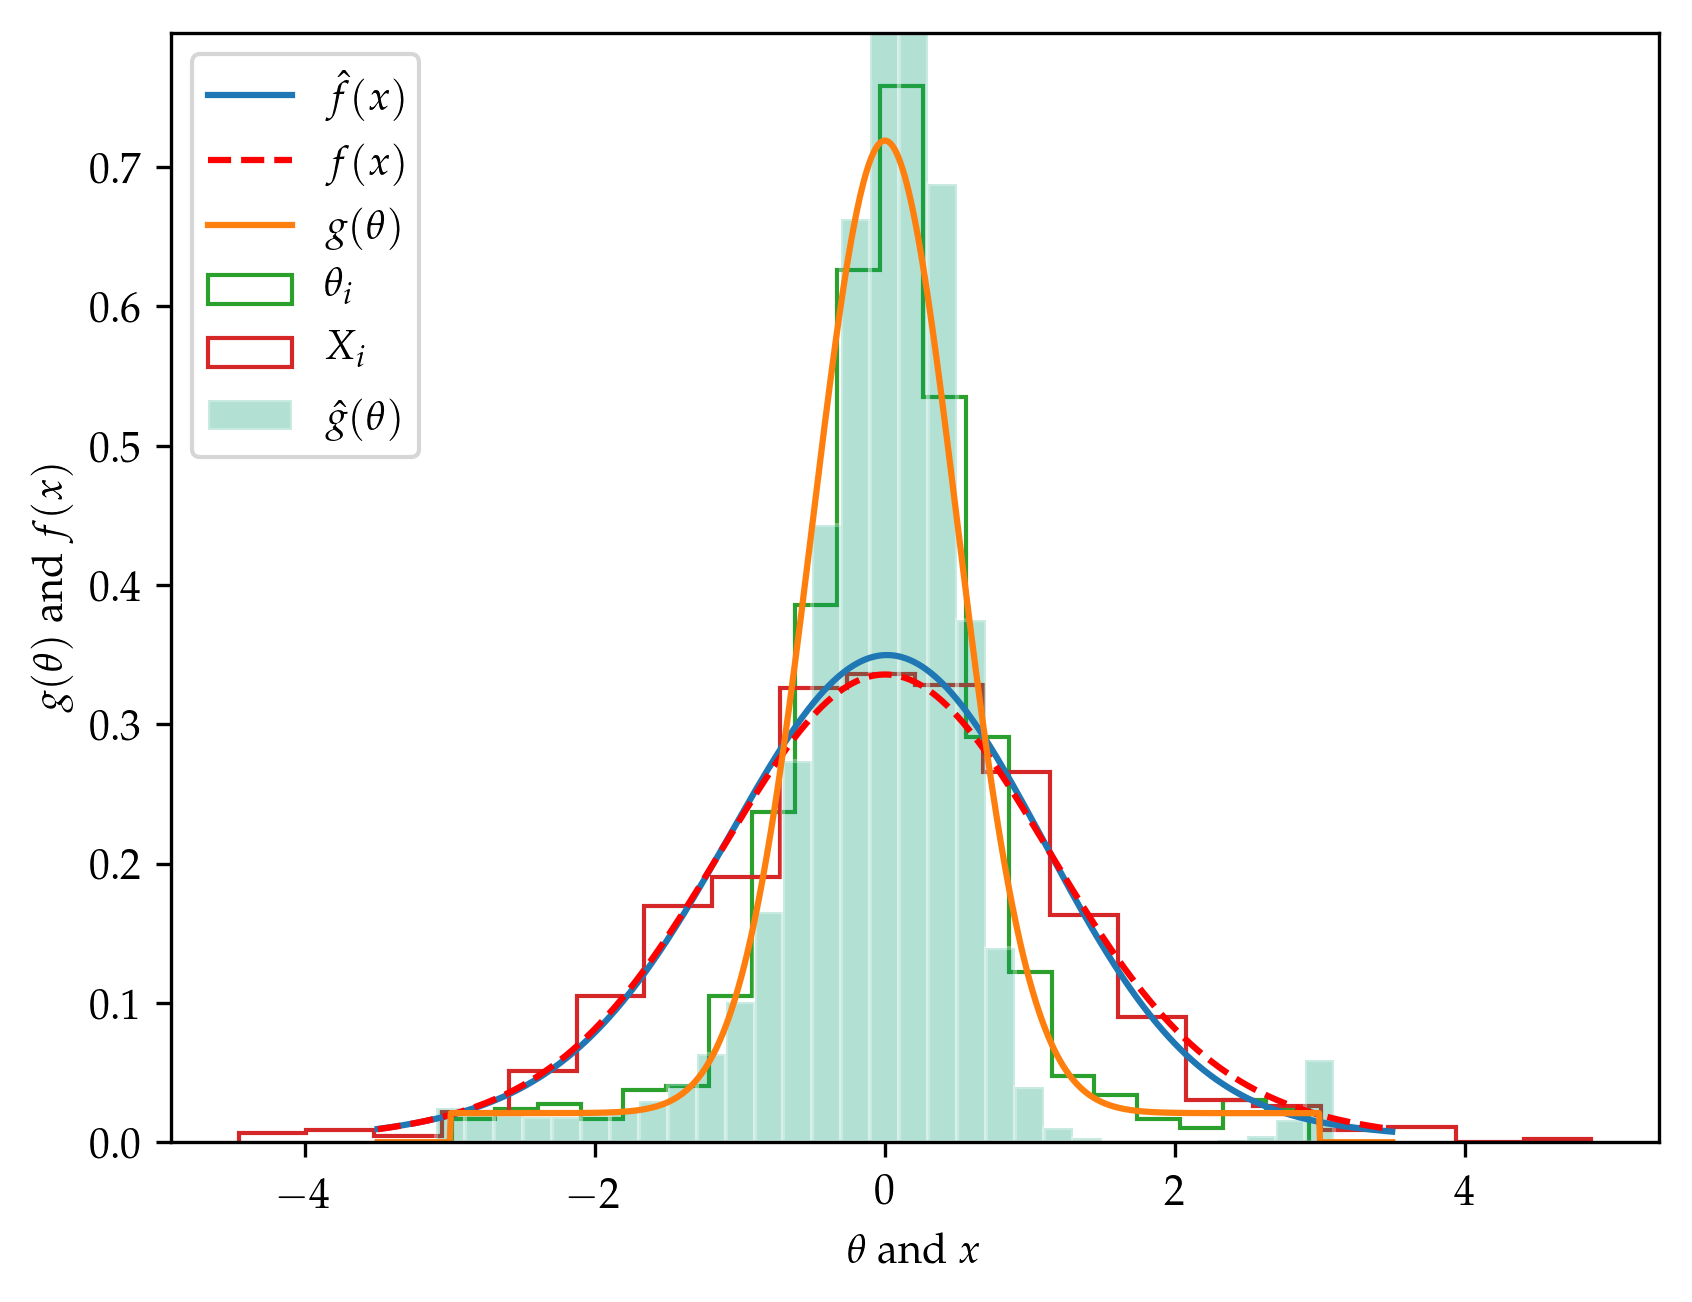

In [47]:
d_optim = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, Optim.minimizer(opt_out))

f_x_unnormalised = exp.([convolved_log_fx(d_optim, d_optim.domain, example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"\hat{f}(x)")

f_x_unnormalised = exp.([convolved_log_fx(example_gθ, linspace(-3.0, 3.0, 51), example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"f(x)", color="red", linestyle="--")

plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
plt.plt[:hist](X_sim, histtype="step", normed=true, label=L"X_i", bins=20)
_ylim = plt.ylim()
plot_pdf(d_optim, label=L"\hat{g}(\theta)"; facecolor=cbbPalette[3], alpha=0.3, edgecolor="white")
plt.ylim(_ylim)
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.legend(loc="upper left")
;

**Next steps:**
- ~~compute the derivative of the PDF using autodiff~~
- ~~compute the derivative of the PDF analytically~~
- ~~maximize the PDF to obtain the MLE given noise-free data~~
- ~~add a noise likelihood and propagate the gradient~~
- ~~maximize the likelihood to obtain the MLE given noisy data~~
- implement regularization?
- make it faster somehow?